**Навигация по уроку**

1. [Использование Yandex Cloud  в своих проектах](https://colab.research.google.com/drive/16coLTMxA7kZNkV9428IqmIhPJxHDPopn)
2. Домашняя работа

1. Ознакомьтесь с настройками Yandex Cloud и разверните [учебный проект](https://storage.yandexcloud.net/academy.ai/projects/quiz_bot_serverless.zip) в облаке из урока 13.2. Придумайте свой квиз на 10 вопросов. Добавьте их в проект.
2. Все вопросы квиза перенесите в таблицу YDB. Храните в таблице с индексом текущего вопроса еще и число набранных очков за этот квиз. При прохождении квиза выведите результат, при прохождении заново - обнулите число очков.
3. Найдите или сгенерируйюте картинку "обложка квиза". Картинка должна отражать тему квиза и выводиться в сообщении бота перед началом квиза. Храните картинку в бакете Object Storage Yandex Cloud. Как создать бакет читайте [здесь](https://cloud.yandex.ru/ru/docs/storage/quickstart).

Файл с проектом Учебного квиза из урока 13.1:
```
https://storage.yandexcloud.net/academy.ai/projects/quiz_bot_serverless.zip
```


#Таблицы базы данных

##доработка quiz_state
 Сначала создал в существующей таблице quiz_state дополнительную колонку stat с типом Uint64 для записи в нее статистики ответов через интерфейс YC

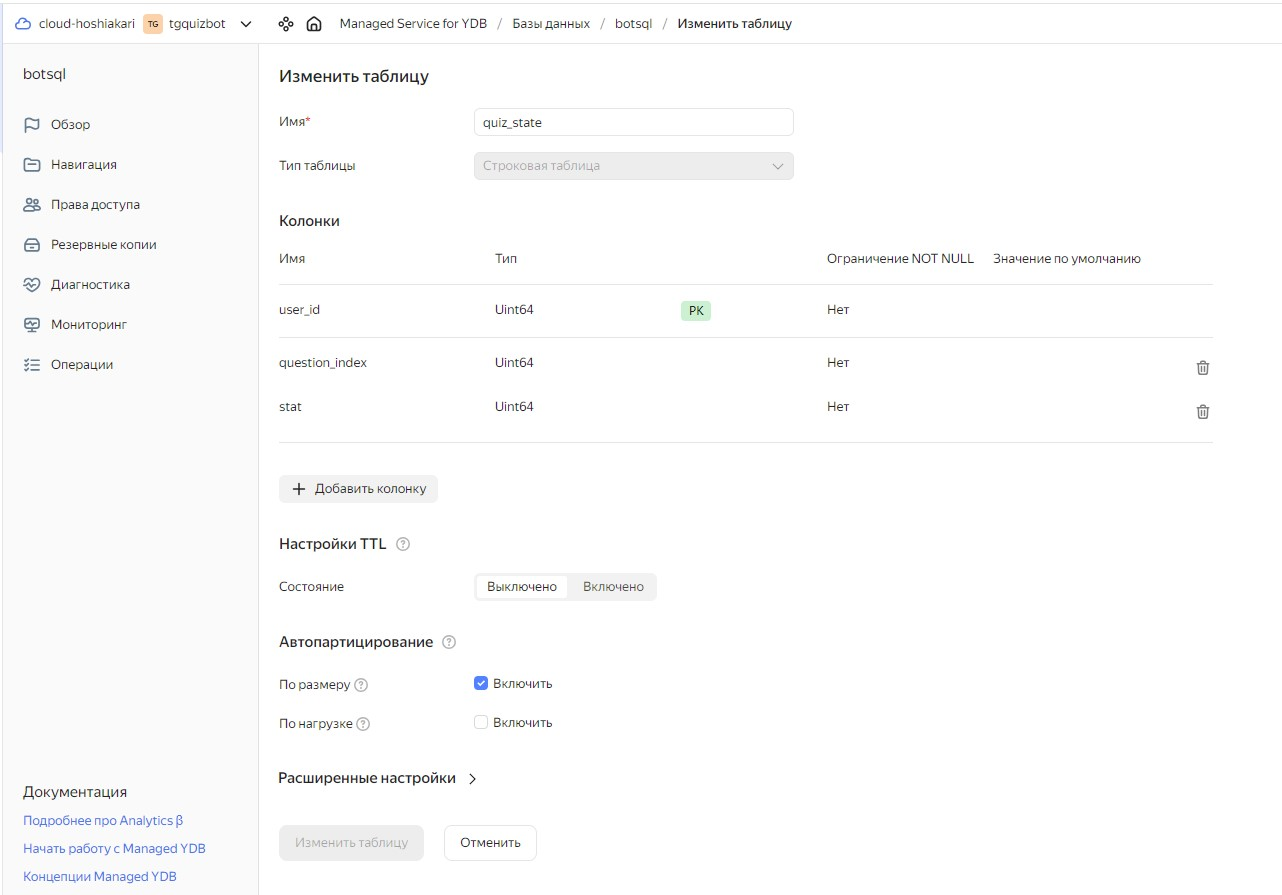

##новая таблица quiz_data
После создал новую таблицу quiz_data для хранения вопросов с помощью SQL запроса
```
CREATE TABLE quiz-data (
    question_id Serial,
    question Utf8,
    options Json,
    correct_index Uint16,
    PRIMARY KEY (question_id)
);
```
При этом для колонки **options** не подошел тип **`List<Utf8>`**, так как YQ поддерживает только примитивные типы данных для вторичных индексов
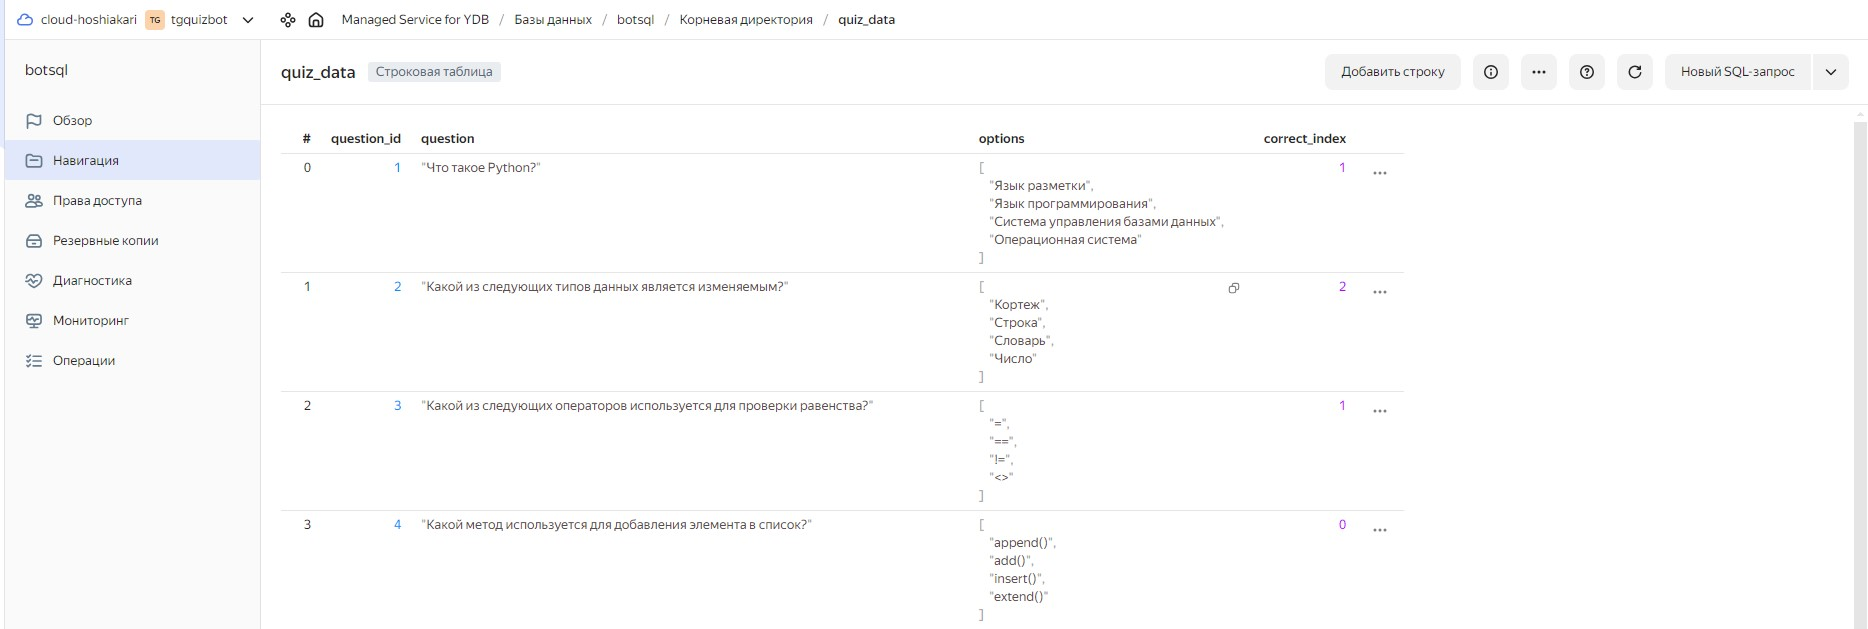

Вставил в нее вопросы путем прямого указания значений для колонкок
```
INSERT INTO quiz_data (question, options, correct_index)
VALUES ("Что такое Python?", ["Язык разметки", "Язык программирования", "Система управления базами данных", "Операционная система"], 1)
```
реализовать вставку в таблицу с помощью кода вида
```
INSERT INTO quiz
SELECT
    question,
    options,
    correct_option
FROM AS_TABLE(
    [
        {
            'question': "Что такое Python?",
            'options': ["Язык программирования", "Тип данных", "Музыкальный инструмент", "Змея на английском"],
            'correct_option': 0
        },
        {
            'question': "Какой тип данных используется для хранения целых чисел?",
            'options': ["int", "float", "str", "natural"],
            'correct_option': 0
        }
    ]
);
```
в любых вариациях не удалось, так и не получилось разобраться, как ее реализовать корректно. Возникала ошибка о неправильной структуре.
В будущем будет проблемно работать таким методом при необходимости вставки больших объемов данных.

#Код функции

##Database.py

###Оригинал

In [ ]:
import os
import ydb

YDB_ENDPOINT = os.getenv("YDB_ENDPOINT")
YDB_DATABASE = os.getenv("YDB_DATABASE")

def get_ydb_pool(ydb_endpoint, ydb_database, timeout=30):
    ydb_driver_config = ydb.DriverConfig(
        ydb_endpoint,
        ydb_database,
        credentials=ydb.credentials_from_env_variables(),
        root_certificates=ydb.load_ydb_root_certificate(),
    )

    ydb_driver = ydb.Driver(ydb_driver_config)
    ydb_driver.wait(fail_fast=True, timeout=timeout)
    return ydb.SessionPool(ydb_driver)


def _format_kwargs(kwargs):
    return {"${}".format(key): value for key, value in kwargs.items()}


# Заготовки из документации
# https://ydb.tech/en/docs/reference/ydb-sdk/example/python/#param-prepared-queries
def execute_update_query(pool, query, **kwargs):
    def callee(session):
        prepared_query = session.prepare(query)
        session.transaction(ydb.SerializableReadWrite()).execute(
            prepared_query, _format_kwargs(kwargs), commit_tx=True
        )

    return pool.retry_operation_sync(callee)


# Заготовки из документации
# https://ydb.tech/en/docs/reference/ydb-sdk/example/python/#param-prepared-queries
def execute_select_query(pool, query, **kwargs):
    def callee(session):
        prepared_query = session.prepare(query)
        result_sets = session.transaction(ydb.SerializableReadWrite()).execute(
            prepared_query, _format_kwargs(kwargs), commit_tx=True
        )
        return result_sets[0].rows

    return pool.retry_operation_sync(callee)

# Зададим настройки базы данных
pool = get_ydb_pool(YDB_ENDPOINT, YDB_DATABASE)


# Структура квиза
quiz_data = [
    {
        'question': 'Что такое Python?',
        'options': ['Язык программирования', 'Тип данных', 'Музыкальный инструмент', 'Змея на английском'],
        'correct_option': 0
    },
    {
        'question': 'Какой тип данных используется для хранения целых чисел?',
        'options': ['int', 'float', 'str', 'natural'],
        'correct_option': 0
    },
    # Добавьте другие вопросы
]


Убрал только quiz_data из кода, т.к. он будет лежать в отдельной таблице

##Handlers.py

###Оригинал

In [ ]:
from aiogram import types, Dispatcher, F, Router
from aiogram.filters import Command, CommandStart, StateFilter, CommandObject, CREATOR
from aiogram.fsm.context import FSMContext
from aiogram.filters.command import Command
from aiogram.utils.keyboard import InlineKeyboardBuilder, ReplyKeyboardBuilder
from database import quiz_data
from service import generate_options_keyboard, get_question, new_quiz, get_quiz_index, update_quiz_index

router = Router()

@router.callback_query(F.data == "right_answer")
async def right_answer(callback: types.CallbackQuery):

    await callback.bot.edit_message_reply_markup(
        chat_id=callback.from_user.id,
        message_id=callback.message.message_id,
        reply_markup=None
    )

    await callback.message.answer("Верно!")
    current_question_index = await get_quiz_index(callback.from_user.id)
    # Обновление номера текущего вопроса в базе данных
    current_question_index += 1
    await update_quiz_index(callback.from_user.id, current_question_index)


    if current_question_index < len(quiz_data):
        await get_question(callback.message, callback.from_user.id)
    else:
        await callback.message.answer("Это был последний вопрос. Квиз завершен!")


@router.callback_query(F.data == "wrong_answer")
async def wrong_answer(callback: types.CallbackQuery):
    await callback.bot.edit_message_reply_markup(
        chat_id=callback.from_user.id,
        message_id=callback.message.message_id,
        reply_markup=None
    )

    # Получение текущего вопроса из словаря состояний пользователя
    current_question_index = await get_quiz_index(callback.from_user.id)
    correct_option = quiz_data[current_question_index]['correct_option']

    await callback.message.answer(f"Неправильно. Правильный ответ: {quiz_data[current_question_index]['options'][correct_option]}")

    # Обновление номера текущего вопроса в базе данных
    current_question_index += 1
    await update_quiz_index(callback.from_user.id, current_question_index)


    if current_question_index < len(quiz_data):
        await get_question(callback.message, callback.from_user.id)
    else:
        await callback.message.answer("Это был последний вопрос. Квиз завершен!")


# Хэндлер на команду /start
@router.message(Command("start"))
async def cmd_start(message: types.Message):
    builder = ReplyKeyboardBuilder()
    builder.add(types.KeyboardButton(text="Начать игру"))
    await message.answer("Добро пожаловать в квиз!", reply_markup=builder.as_markup(resize_keyboard=True))


# Хэндлер на команду /quiz
@router.message(F.text=="Начать игру")
@router.message(Command("quiz"))
async def cmd_quiz(message: types.Message):

    await message.answer(f"Давайте начнем квиз!")
    await new_quiz(message)




###Доработка

In [ ]:
from aiogram import types, Dispatcher, F, Router
from aiogram.filters import Command, CommandStart, StateFilter, CommandObject, CREATOR
from aiogram.fsm.context import FSMContext
from aiogram.filters.command import Command
from aiogram.utils.keyboard import InlineKeyboardBuilder, ReplyKeyboardBuilder

from service import generate_options_keyboard, get_question, new_quiz, get_quiz_index, update_quiz_index, quiz_len, get_quiz_data

router = Router()

@router.callback_query(F.data == "right_answer")
async def right_answer(callback: types.CallbackQuery):

    await callback.bot.edit_message_reply_markup(
        chat_id=callback.from_user.id,
        message_id=callback.message.message_id,
        reply_markup=None
    )

###
# далее в коде quiz_stat получает словарь из функции get_quiz_index с ключами "current_question_index" и "stat"
###
    await callback.message.answer("Верно!")
    quiz_stat = await get_quiz_index(callback.from_user.id)
    current_question_index = quiz_stat["current_question_index"]
    stat = quiz_stat["stat"]
    # Обновление номера текущего вопроса и статистики в базе данных
    current_question_index += 1
    stat += 1
    await update_quiz_index(callback.from_user.id, current_question_index, stat)

###
# заменил len(quiz_data) на переменную quiz_len, взятую из service
###

    if current_question_index < quiz_len:
        await get_question(callback.message, callback.from_user.id)
    else:
        await callback.message.answer(f"Это был последний вопрос. Квиз завершен!\n Ваш результат {stat} из {quiz_len} ответов правильные")

@router.callback_query(F.data == "wrong_answer")
async def wrong_answer(callback: types.CallbackQuery):
    await callback.bot.edit_message_reply_markup(
        chat_id=callback.from_user.id,
        message_id=callback.message.message_id,
        reply_markup=None
    )

    # Получение текущего вопроса и статистики из словаря состояний пользователя
    quiz_stat = await get_quiz_index(callback.from_user.id)
    current_question_index = quiz_stat["current_question_index"]
    stat = quiz_stat["stat"]

###
# далее quiz_data получает словарь из функции get_quiz_data с ключами "question", "options", "correct_index"
###

    quiz_data = await get_quiz_data(current_question_index)
    correct_option = quiz_data["options"][quiz_data["correct_index"]]

    await callback.message.answer(f"Неправильно. Правильный ответ: {correct_option}")

    # Обновление номера текущего вопроса в базе данных
    current_question_index += 1
    await update_quiz_index(callback.from_user.id, current_question_index, stat)

    if current_question_index < quiz_len:
        await get_question(callback.message, callback.from_user.id)
    else:
        await callback.message.answer(f"Это был последний вопрос. Квиз завершен!\n Ваш результат {stat} из {quiz_len} ответов правильные")

# Хэндлер на команду /start
@router.message(Command("start"))
async def cmd_start(message: types.Message):
    builder = ReplyKeyboardBuilder()
    builder.add(types.KeyboardButton(text="Начать игру"))
    await message.answer("Добро пожаловать в квиз!", reply_markup=builder.as_markup(resize_keyboard=True))

IMAGE_URL = "https://storage.yandexcloud.net/quiz.pic/quiz_start.jpg"
# Хэндлер на команду /quiz
@router.message(F.text=="Начать игру")
@router.message(Command("quiz"))
async def cmd_quiz(message: types.Message):

###
# добавил картинку на команду "quiz", которая загружается в сообщении методом .answer_photo
###
    await message.answer_photo(
        photo=IMAGE_URL,
        caption=f"Давайте начнем квиз!")

    await new_quiz(message)

- убрал `from database import quiz_data` за ненадобностью

- добавил в импорт `quiz_len, get_quiz_data` из `service`

- обновил обращения к функциям с параметрами, добавив где необходимо параметр stat в обновление/извлечение таблицы

##Service.py

###Оригинал

In [ ]:
from  database import pool, execute_update_query, execute_select_query
from aiogram.utils.keyboard import InlineKeyboardBuilder, ReplyKeyboardBuilder
from aiogram import types
from database import quiz_data

def generate_options_keyboard(answer_options, right_answer):
    builder = InlineKeyboardBuilder()

    for option in answer_options:
        builder.add(types.InlineKeyboardButton(
            text=option,
            callback_data="right_answer" if option == right_answer else "wrong_answer")
        )

    builder.adjust(1)
    return builder.as_markup()

async def get_question(message, user_id):

    # Получение текущего вопроса из словаря состояний пользователя
    current_question_index = await get_quiz_index(user_id)
    print(current_question_index)
    correct_index = quiz_data[current_question_index]['correct_option']
    opts = quiz_data[current_question_index]['options']
    kb = generate_options_keyboard(opts, opts[correct_index])
    await message.answer(f"{quiz_data[current_question_index]['question']}", reply_markup=kb)

async def new_quiz(message):
    user_id = message.from_user.id
    current_question_index = 0
    await update_quiz_index(user_id, current_question_index)
    await get_question(message, user_id)

async def get_quiz_index(user_id):
    get_user_index = f"""
        DECLARE $user_id AS Uint64;

        SELECT question_index
        FROM `quiz_state`
        WHERE user_id == $user_id;
    """
    results = execute_select_query(pool, get_user_index, user_id=user_id)

    if len(results) == 0:
        return 0
    if results[0]["question_index"] is None:
        return 0
    return results[0]["question_index"]

async def update_quiz_index(user_id, question_index):
    set_quiz_state = f"""
        DECLARE $user_id AS Uint64;
        DECLARE $question_index AS Uint64;

        UPSERT INTO `quiz_state` (`user_id`, `question_index`)
        VALUES ($user_id, $question_index);
    """

    execute_update_query(
        pool,
        set_quiz_state,
        user_id=user_id,
        question_index=question_index,
    )

###Доработка

In [ ]:
from  database import pool, execute_update_query, execute_select_query
from aiogram.utils.keyboard import InlineKeyboardBuilder, ReplyKeyboardBuilder
from aiogram import types
import json

def generate_options_keyboard(answer_options, right_answer):
    builder = InlineKeyboardBuilder()

    for option in answer_options:
        builder.add(types.InlineKeyboardButton(
            text=option,
            callback_data="right_answer" if option == right_answer else "wrong_answer")
        )

    builder.adjust(1)
    return builder.as_markup()

async def get_question(message, user_id):

    # Получение текущего вопроса из словаря состояний пользователя
    quiz_stat = await get_quiz_index(user_id)
    current_question_index = quiz_stat["current_question_index"]
    stat = quiz_stat["stat"]
    print(current_question_index)
    quiz_data = await get_quiz_data(current_question_index)
    correct_index = quiz_data["correct_index"]
    opts = quiz_data["options"]
    kb = generate_options_keyboard(opts, opts[correct_index])
    await message.answer(f'{quiz_data["question"]}', reply_markup=kb)

# добавил обнуление stat при старте, и сброс вопроса в позицию 1
# 1 а не 0 т.к. таблица в базе нумеруется начиная с 1
async def new_quiz(message):
    user_id = message.from_user.id
    current_question_index = 1
    stat = 0
    await update_quiz_index(user_id, current_question_index, stat)
    await get_question(message, user_id)

async def get_quiz_data(question_id):
    get_question_data = f"""
        DECLARE $question_id AS Int32;

        SELECT question, options, correct_index
        FROM `quiz_data`
        WHERE  question_id == $question_id;
    """
    results = execute_select_query(pool, get_question_data, question_id=question_id)
    options = json.loads(results[0]["options"])
    return {"question": results[0]["question"],
            "options": options,
            "correct_index": results[0]["correct_index"]}

def get_last_question_id(pool):
    get_last_id = f"""
        SELECT MAX(question_id) AS last_id
        FROM `quiz_data`
    """
    results = execute_select_query(pool, get_last_id)
    return results[0]["last_id"]

quiz_len = get_last_question_id(pool)

# добавил параметр stat в запрос
async def get_quiz_index(user_id):
    get_user_index = f"""
        DECLARE $user_id AS Uint64;

        SELECT question_index, stat
        FROM `quiz_state`
        WHERE user_id == $user_id;
    """
    results = execute_select_query(pool, get_user_index, user_id=user_id)

    if len(results) == 0:
        return 1
    if results[0]["question_index"] is None:
        return 1
    return {"current_question_index": results[0]["question_index"],
            "stat": results[0]["stat"]}

# добавил параметр stat в запрос
async def update_quiz_index(user_id, question_index, stat):
    set_quiz_state = f"""
        DECLARE $user_id AS Uint64;
        DECLARE $question_index AS Uint64;
        DECLARE $stat AS Uint64;
        UPSERT INTO `quiz_state` (`user_id`, `question_index`, `stat`)
        VALUES ($user_id, $question_index, $stat);
    """

    execute_update_query(
        pool,
        set_quiz_state,
        user_id=user_id,
        question_index=question_index,
        stat=stat,
    )

- убрал импорт quiz_data

- добавил импорт json

- `get_quiz_inedx` теперь еще получает параметр `stat` из таблицы `quiz_state` и возвращает словарь с ключами "current_question_index", "stat" . В случае, когда пользователь новый - функция возвращает 1, начиная с первого вопроса вбазе. В return вернул словарь для удобства выбора значений и чтения кода

- добавил функцию `get_quiz_data`, которая запрашивает колонки question, options, correct_index из таблицы quiz_data. В теле функции добавил преобразование json в список `options = json.loads(results[0]["options"])`, без нее строка в колонке возвращается целиком не преобразованной в список и клавиатура генерируется для каждого символа. Функция так же возвращает словарь с ключами соответствующими названию колонки

- добавил функцию `get_last_question_id`, которая получает последний индекс в базе `quiz_data` и переменную `quiz_len`, которой присваивается это значение. **Потенциальные проблемы** - при удалении строки где то в середине базы количество вопросов не будет соответствовать последнему индексу базы

#Картинка квиза

##Бакет
Создал бакет в YC для загрузки туда картинки
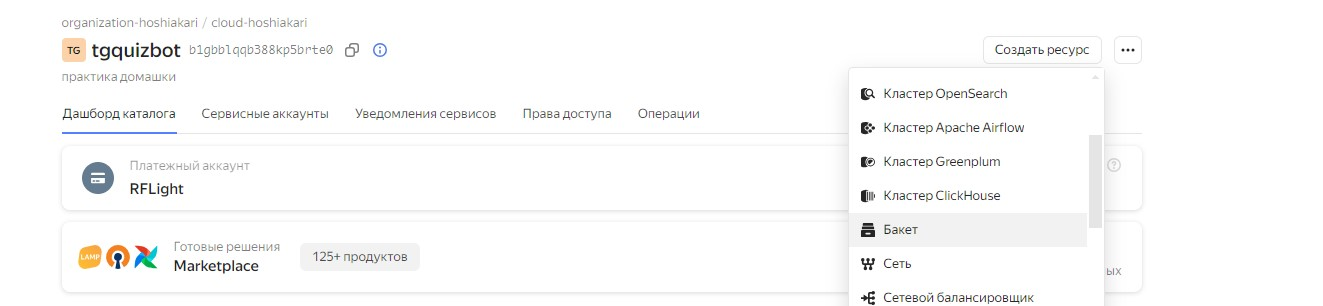


#Итоговый вид

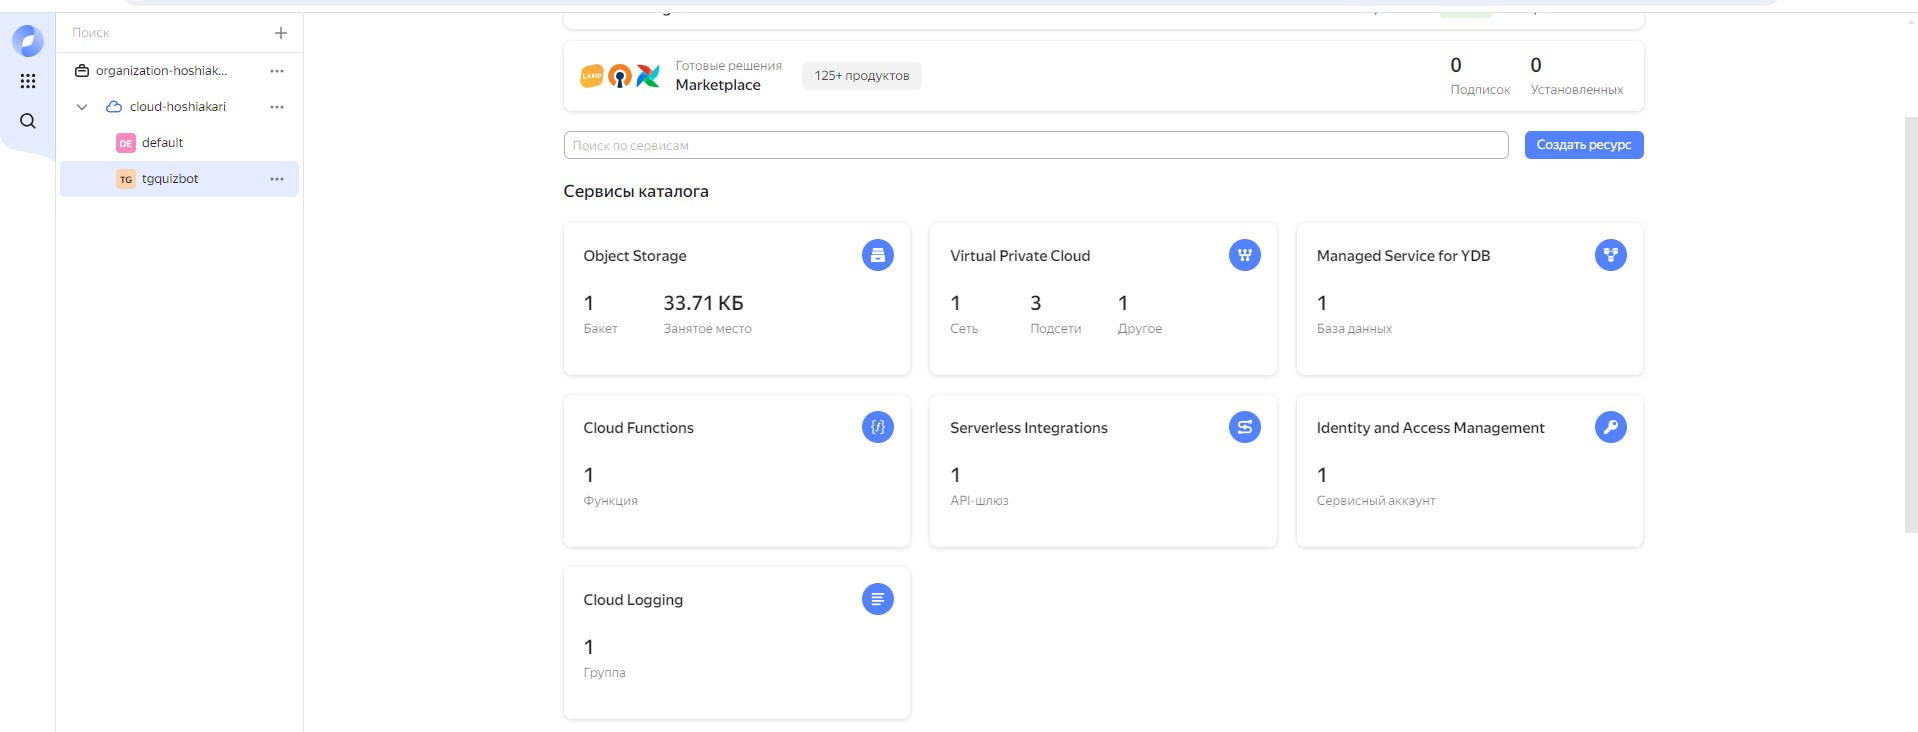

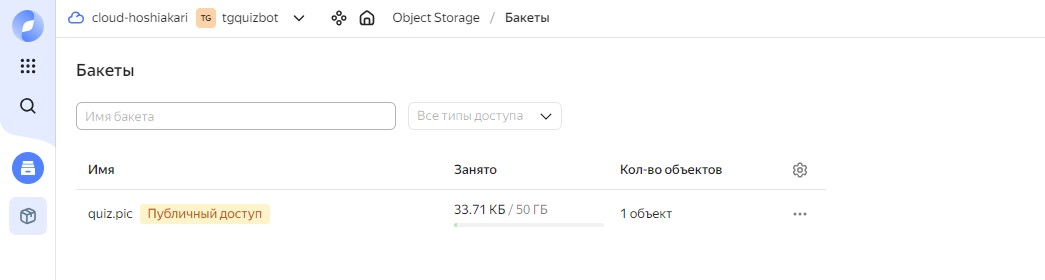

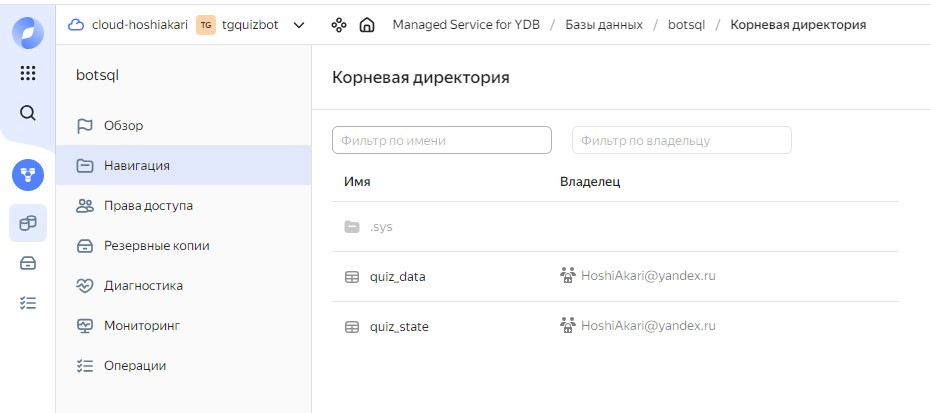

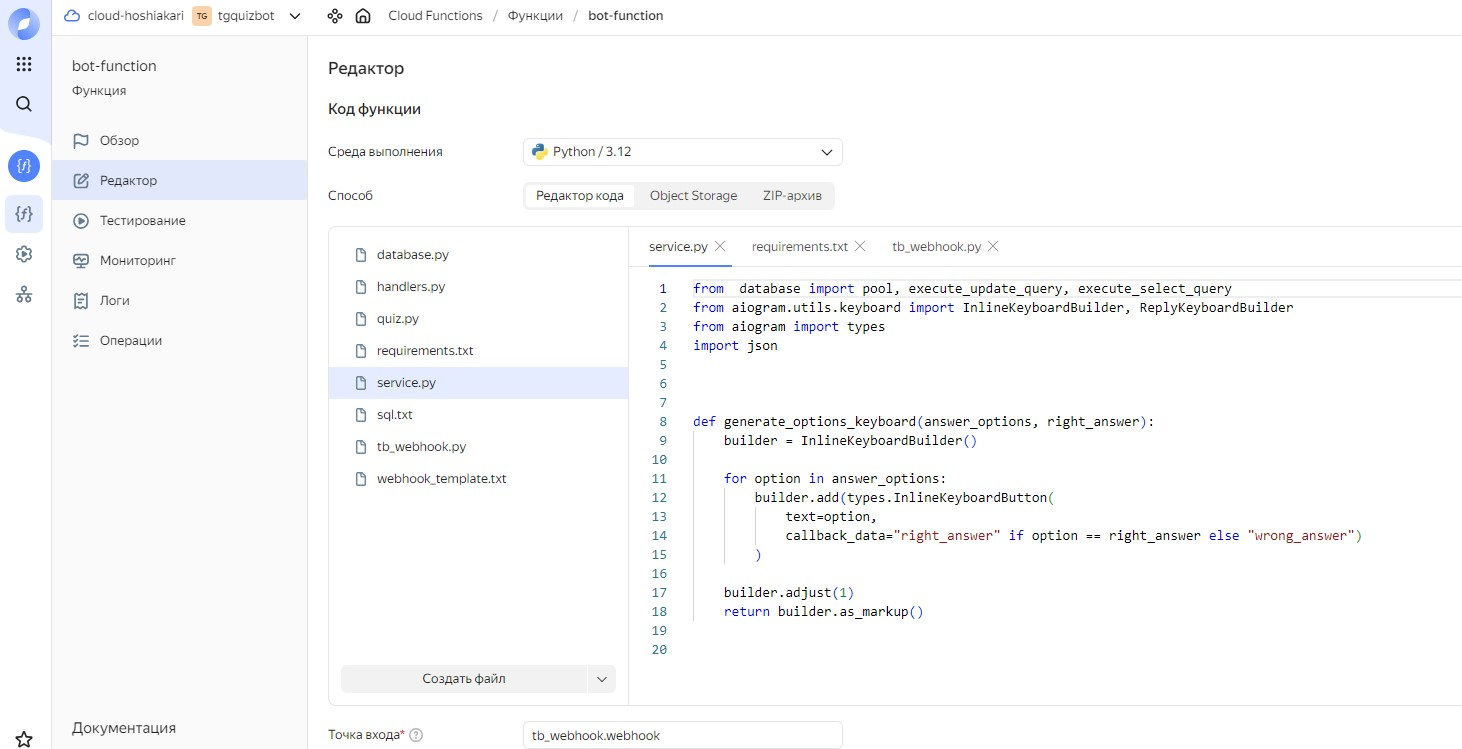

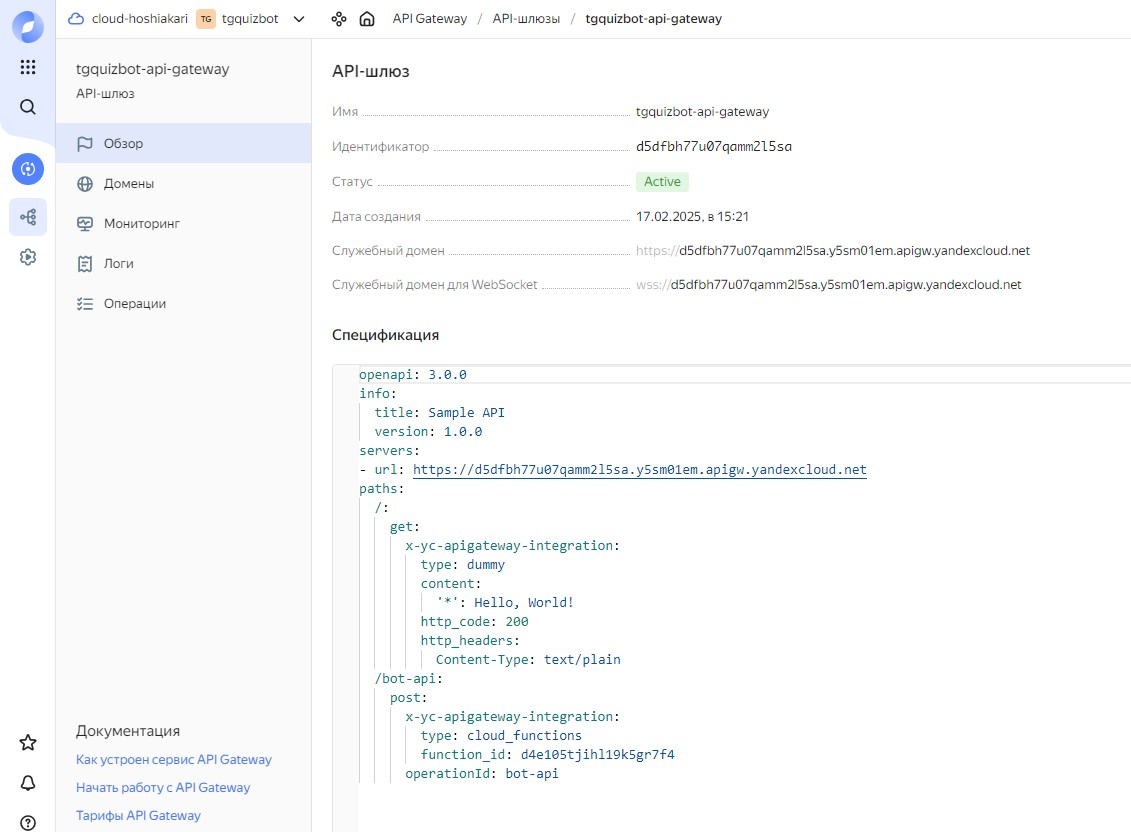

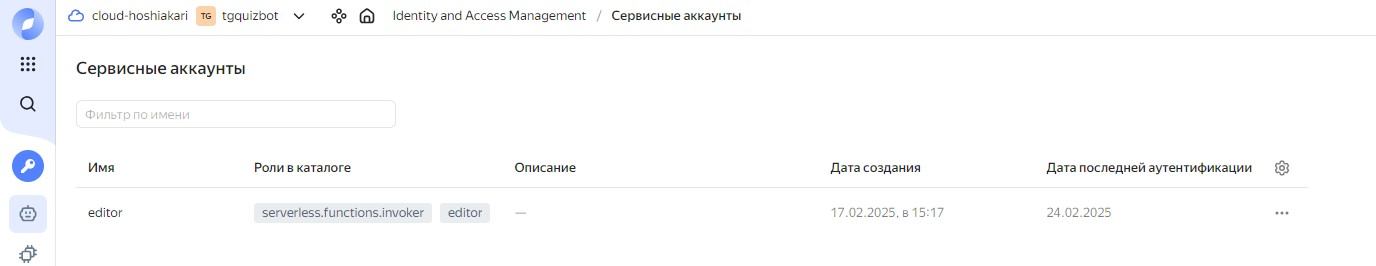

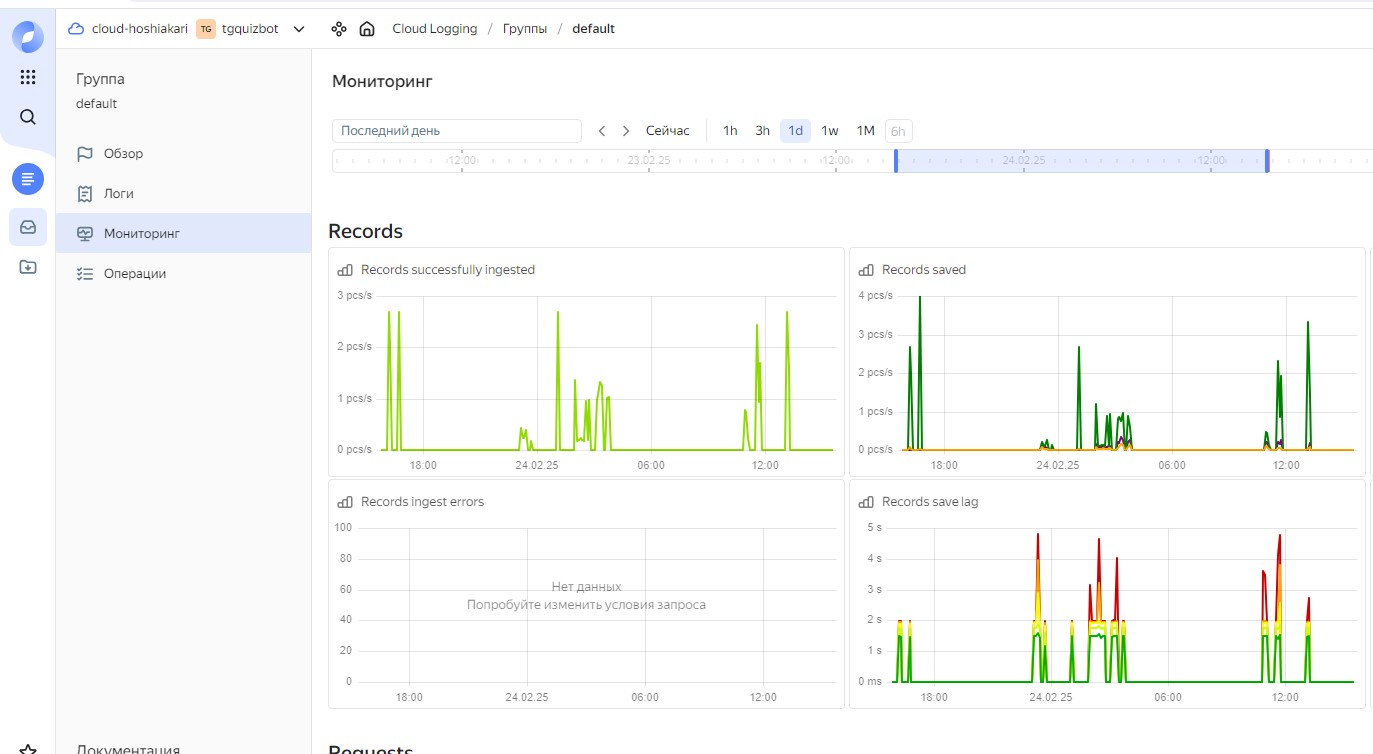

Отмечу для себя, что отладка в YC была крайне мучительной, т.к. не обладал инструментами для отслеживания ошибок в разных файлах функции YC, а логи передавались большим списком последовательностей выполнения внутренних функций. Возможно, есть средства отслеживания конкретных действий, а не всей цепочки исполнения, с помощью кода для логов, если укажете способы применения таких способов - буду благодарен.